<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/schrodinger/schrodinger_base1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda
Epoch 0, Loss: 3.938979e+01, E: 0.501000
Epoch 500, Loss: 1.776940e-04, E: 0.524360
Epoch 1000, Loss: 7.561137e-05, E: 0.524410
Epoch 1500, Loss: 4.351474e-05, E: 0.524303
Epoch 2000, Loss: 2.840989e-05, E: 0.524105
Epoch 2500, Loss: 1.765979e-05, E: 0.525838
Epoch 3000, Loss: 9.167834e-06, E: 0.535140
Epoch 3500, Loss: 2.494546e-05, E: 0.548563
Epoch 4000, Loss: 3.917946e-06, E: 0.548129
Epoch 4500, Loss: 2.847424e-06, E: 0.558262
Epoch 5000, Loss: 2.226426e-06, E: 0.557757
Epoch 5500, Loss: 1.596236e-06, E: 0.568731
Epoch 6000, Loss: 2.833999e-04, E: 0.578263
Epoch 6500, Loss: 1.492707e-06, E: 0.584534
Epoch 7000, Loss: 3.938747e-06, E: 0.600232
Epoch 7500, Loss: 1.962146e-05, E: 0.612660
Epoch 8000, Loss: 2.305251e-06, E: 0.625568
Epoch 8500, Loss: 2.587331e-05, E: 0.642401
Epoch 9000, Loss: 5.842163e-03, E: 0.663536
Epoch 9500, Loss: 9.041351e-05, E: 0.685104
Epoch 10000, Loss: 2.642708e-06, E: 0.833441
Epoch 10500, Loss: 1.394539e-06, E: 0.833684
Epoch 11000, Loss: 7.93

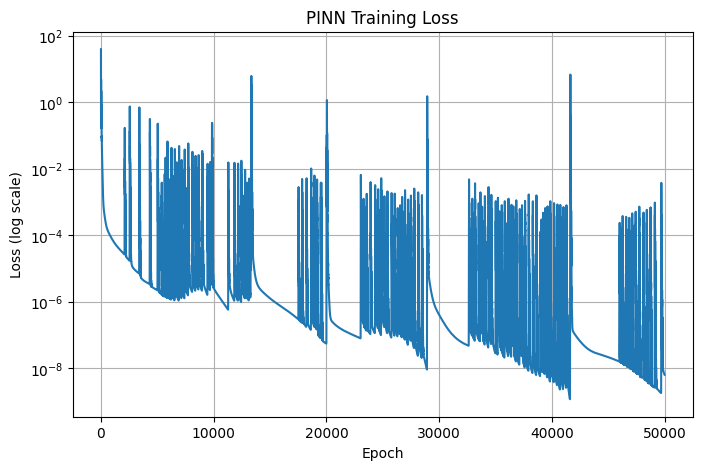

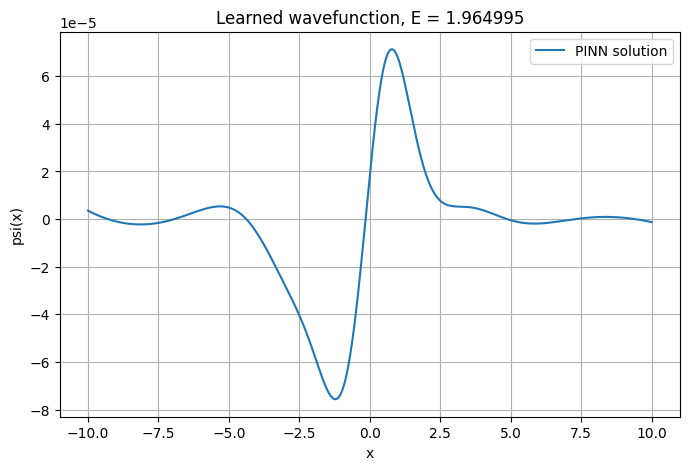

In [2]:
# -----------------------
# Imports
# -----------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# -----------------------
# Problem Definition
# -----------------------
L = 10.0                      # domain half-width
domain = [-L, L]
V = lambda x: 0.5 * x**2     # harmonic oscillator potential

# -----------------------
# PINN definition
# -----------------------
class SchrodingerPINN(nn.Module):
    def __init__(self, hidden_dim=50, hidden_layers=3):
        super().__init__()
        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
        # learnable energy parameter
        self.E = nn.Parameter(torch.tensor(0.5, device=device))  # initial guess
    def forward(self, x):
        return self.net(x)

# -----------------------
# Model + Optimizer
# -----------------------
model = SchrodingerPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# Collocation points
# -----------------------
N_colloc = 10000
x_colloc = torch.linspace(domain[0], domain[1], N_colloc, device=device).view(-1,1)
x_colloc.requires_grad_(True)

# Boundary points
x_bc = torch.tensor([[domain[0]], [domain[1]]], device=device)

# -----------------------
# Training loop
# -----------------------
loss_history = []
epochs = 50000

for epoch in range(epochs):
    optimizer.zero_grad()

    # network prediction
    psi = model(x_colloc)

    # first derivative
    psi_x = torch.autograd.grad(psi, x_colloc, torch.ones_like(psi), create_graph=True)[0]
    # second derivative
    psi_xx = torch.autograd.grad(psi_x, x_colloc, torch.ones_like(psi_x), create_graph=True)[0]

    # residual
    residual = psi_xx + 2*(model.E - V(x_colloc)) * psi
    loss_pde = torch.mean(residual**2)

    # boundary loss
    psi_bc = model(x_bc)
    loss_bc = torch.mean(psi_bc**2)

    # total loss
    loss = loss_pde + loss_bc

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6e}, E: {model.E.item():.6f}")

print(f"Final learned energy: {model.E.item():.6f}")

# -----------------------
# Plotting
# -----------------------
plt.figure(figsize=(8,5))
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("PINN Training Loss")
plt.grid()
plt.show()

# Final wavefunction plot
x_plot = torch.linspace(domain[0], domain[1], 500, device=device).view(-1,1)
with torch.no_grad():
    psi_plot = model(x_plot).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(x_plot.cpu().numpy(), psi_plot, label="PINN solution")
plt.xlabel("x")
plt.ylabel("psi(x)")
plt.title(f"Learned wavefunction, E = {model.E.item():.6f}")
plt.grid()
plt.legend()
plt.show()
